In [1]:
from phoenix import potentials, distributionfunctions, sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential as Phi
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions.py:10: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions.py:38: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite ty

In [2]:
#define parameters
params = {
    "R0": 8.0, # for actions to phase space
    "Rinit": 8.0, # for sampling
    "R0_thin": 5.0,
    "Rd_thin": 2.5,
    "Sigma0_thin": 100.0,
    "RsigR_thin": 8.0,
    "RsigZ_thin": 8.0,
    "sigmaR0_R0_thin": 40.0,
    "sigmaz0_R0_thin": 25.0,
    "L0_thin": 50.0,
    "Rinit_for_Rc_thin": 8.0,
    "R0_thick": 8.0,
    "Rd_thick": 2.0,
    "Sigma0_thick": 150.0,
    "RsigR_thick": 8.0,
    "RsigZ_thick": 4.0,
    "sigmaR0_R0_thick": 60.0,
    "sigmaz0_R0_thick": 40.0,
    "L0_thick": 50.0,
    "Rinit_for_Rc_thick": 8.0,
    "f_thin": 0.8,
    "f_thick": 0.2,
}

envelope_max = 3.0
n_candidates = 500_000
key = jax.random.PRNGKey(42)

#theta = (1e12, 20.0, 20.0)  # (M, a, b) z.B. für Miyamoto–Nagai
#theta_target = (1e12, 5.0, 2.0)  # (M, a, b) z.B. für Miyamoto–Nagai
theta = jnp.array([1e12, 20.0, 20.0])
theta_target = jnp.array([1e12, 50.0, 200.0])

In [ ]:
#from parameters to phase space coordinates
@jax.jit
def params_to_phasespace(params, theta = theta, Phi= Phi, key=key, n_candidates=n_candidates, envelope_max=envelope_max):
    candidates, samples, soft_weights = sampling.sample_df_potential(key, params, Phi, theta, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi, theta)
    return phase_space_coords, samples, soft_weights

In [ ]:
phase_space_coords, samples, soft_weights = params_to_phasespace(params)

In [ ]:
# --- Setup ---
# Initial Guess for Potential Parameters (M, a, b)
# e.g. M=1e12, a=10, b=5
theta_current = jnp.array([1e12, 10.0, 5.0]) 

# Optimizer (Adam is robust for this)
learning_rate = 0.05
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(theta_current)

# JIT-compiled update step
@jax.jit
def step(theta, opt_state, key):
    # Calculate gradients
    loss_val, grads = jax.value_and_grad(consistency_loss)(theta, params, key)
    
    # Apply updates
    updates, opt_state = optimizer.update(grads, opt_state)
    theta_new = optax.apply_updates(theta, updates)
    
    return theta_new, opt_state, loss_val

# --- The Loop ---
print(f"Starting Optimization. Initial Theta: {theta_current}")

key = jax.random.PRNGKey(42) # Master key

for i in range(200): # 200 iterations
    # Split key for stochastic sampling
    key, subkey = jax.random.split(key)
    
    # Perform optimization step
    theta_current, opt_state, loss = step(theta_current, opt_state, subkey)
    
    if i % 10 == 0:
        print(f"Step {i:03d} | Loss: {loss:.5f} | Theta: {theta_current}")

print("--------------------------------")
print(f"Optimization Finished.")
print(f"Self-Consistent Potential Parameters: {theta_current}")

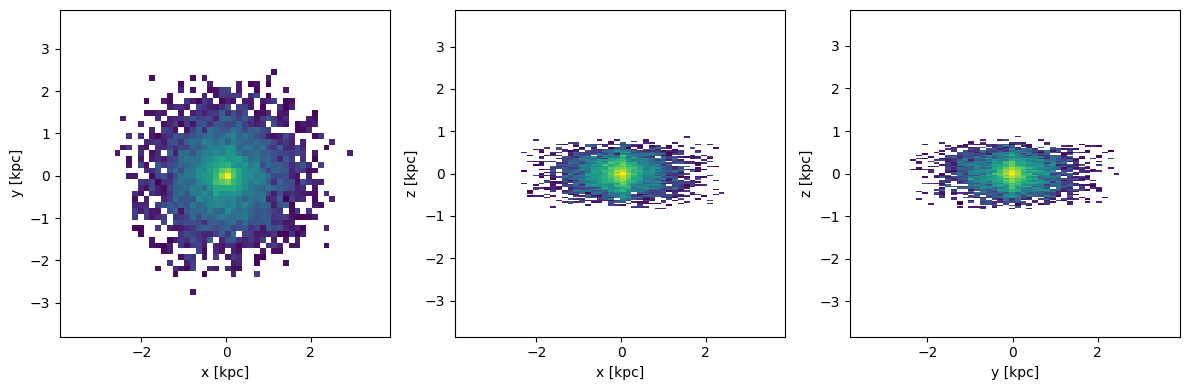

In [ ]:
phase_space_coords, samples, soft_weights = params_to_phasespace(params)

x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]

import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist2d(x, y, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hist2d(x, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hist2d(y, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()